# Example usage of gw_eccentricity

Package to measure eccentricity and mean anomaly from a gravitational waveform.    
For package details, see https://pypi.org/project/gw_eccentricity   
Paper: FIXME ARIF

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import h5py
import os, sys, subprocess

from gw_eccentricity import measure_eccentricity
from gw_eccentricity import get_available_methods
from gw_eccentricity.plot_settings import use_fancy_plotsettings

use_fancy_plotsettings()

## Read the documentation

In [2]:
help(measure_eccentricity)

Help on function measure_eccentricity in module gw_eccentricity.gw_eccentricity:

measure_eccentricity(tref_in=None, fref_in=None, method='Amplitude', dataDict=None, return_gwecc_object=False, spline_kwargs=None, extra_kwargs=None)
    Measure eccentricity and mean anomaly from a gravitational waveform.
    
    Eccentricity is measured using the GW frequency omega22(t) = dphi22(t)/dt,
    where phi22(t) is the phase of the (2,2) waveform mode. We evaluate
    omega22(t) at pericenter times, t_pericenters, and build a spline interpolant
    omega22_pericenters(t) using those points. Similarly, we build omega22_apocenters(t)
    using the apocenter times, t_apocenters. To find the pericenter/apocenter
    locations, one can look for extrema in different waveform data, like
    omega22(t) or Amp22(t), the amplitude of the (2,2) mode. Pericenters
    correspond to pericenters, while apocenters correspond to apocenters in the data.
    The method option (described below) lets you pick whic

## Load example data

As an example, we use an eccentric, equal-mass nonspinning binary black hole waveform from the SXS catalog and the corresponding zero eccentricity waveform using the NRHybSur3dq8 model.

In [3]:
# Get the path to the base directory of the repo
git_home = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip('\n')

# Load the eccentric NR waveform and the corresponding zero-ecc surrogate waveform
f = h5py.File(f"{git_home}/data/SXS_BBH_2305_22.h5", "r")
t_ecc_NR, h22_ecc_NR = f["t"][:], f["h22"][:]
t_zeroecc_sur, h22_zeroecc_sur = f["t_zeroecc"][:], f["h22_zeroecc"][:]

# Setup dataDict (Note the required format)
dataDict = {"t": t_ecc_NR,
           "hlm": {(2, 2): h22_ecc_NR},
           "t_zeroecc": t_zeroecc_sur,
           "hlm_zeroecc": {(2, 2): h22_zeroecc_sur}}
f.close()

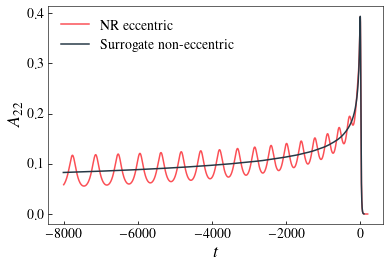

In [4]:
# Plot the two waveforms
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="NR eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="Surrogate non-eccentric")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$A_{22}$");

# Usage

## Get the available methods

We implement different methods to measure eccentricity and mean anomaly.   
Recommended methods are 'Amplitude' or 'ResidualAmplitude'.   
See the documentation above for what different methods do.  

In [5]:
get_available_methods()

['Amplitude',
 'Frequency',
 'ResidualAmplitude',
 'ResidualFrequency',
 'FrequencyFits']

#### Measure eccentricity/mean_ano at a single time

In [6]:
tref_in = -5500
for method in get_available_methods():
    tref_out, ecc_ref, meanAno_ref = measure_eccentricity(tref_in=tref_in,
                                                         method=method,
                                                         dataDict=dataDict,
                                                         extra_kwargs={"debug": False})
    print(f"method={method:20s} ecc={ecc_ref:.6f}, meanAno = {meanAno_ref:.6f}")

method=Amplitude            ecc=0.178461, meanAno = 4.915010
method=Frequency            ecc=0.178436, meanAno = 4.915923
method=ResidualAmplitude    ecc=0.178487, meanAno = 4.919442
method=ResidualFrequency    ecc=0.178489, meanAno = 4.921472
method=FrequencyFits        ecc=0.178516, meanAno = 4.921232


#### Measure eccentricity/mean_ano at a single frequency

In [7]:
fref_in = 0.005
for method in get_available_methods():
    fref_out, ecc_ref, meanAno_ref = measure_eccentricity(fref_in=fref_in,
                                                         method=method,
                                                         dataDict=dataDict,
                                                         extra_kwargs={"debug": False})
    print(f"method={method:20s} ecc={ecc_ref:.6f}, meanAno = {meanAno_ref:.6f}")

method=Amplitude            ecc=0.171609, meanAno = 5.025760
method=Frequency            ecc=0.171602, meanAno = 5.022534
method=ResidualAmplitude    ecc=0.171628, meanAno = 5.030301
method=ResidualFrequency    ecc=0.171633, meanAno = 5.035898
method=FrequencyFits        ecc=0.171627, meanAno = 5.035287


**NOTE:** In the similar way, one can measure the eccentricity and mean anomaly at an array of times/frequencies also.

### Making diagnostic plots

The library comes with useful way to make diagnostic plots when the resulting eccentricty does not look good. Each of the plots could be used to investigate different issues that might be causing the unwanted features in the measured eccentricity.

For demonstration purpose, let's try measuring the eccentricity at an array of times using only `ResidualAmplitude` method

In [8]:
tref_in = dataDict["t"]

The diagnostic plots are available through the eccentricity measurement module object. Therefore, we return this object this time as well

In [9]:
method = "ResidualAmplitude"
tref_out, ecc_ref, meanAno_ref, gwecc_object = measure_eccentricity(tref_in=tref_in,
                                                                 method=method,
                                                                 dataDict=dataDict,
                                                                 return_gwecc_object=True,
                                                                 extra_kwargs={"debug": False})

/Users/vijay/Work/Projects/Current/gw_eccentricity/gw_eccentricity/eccDefinition.py:540: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


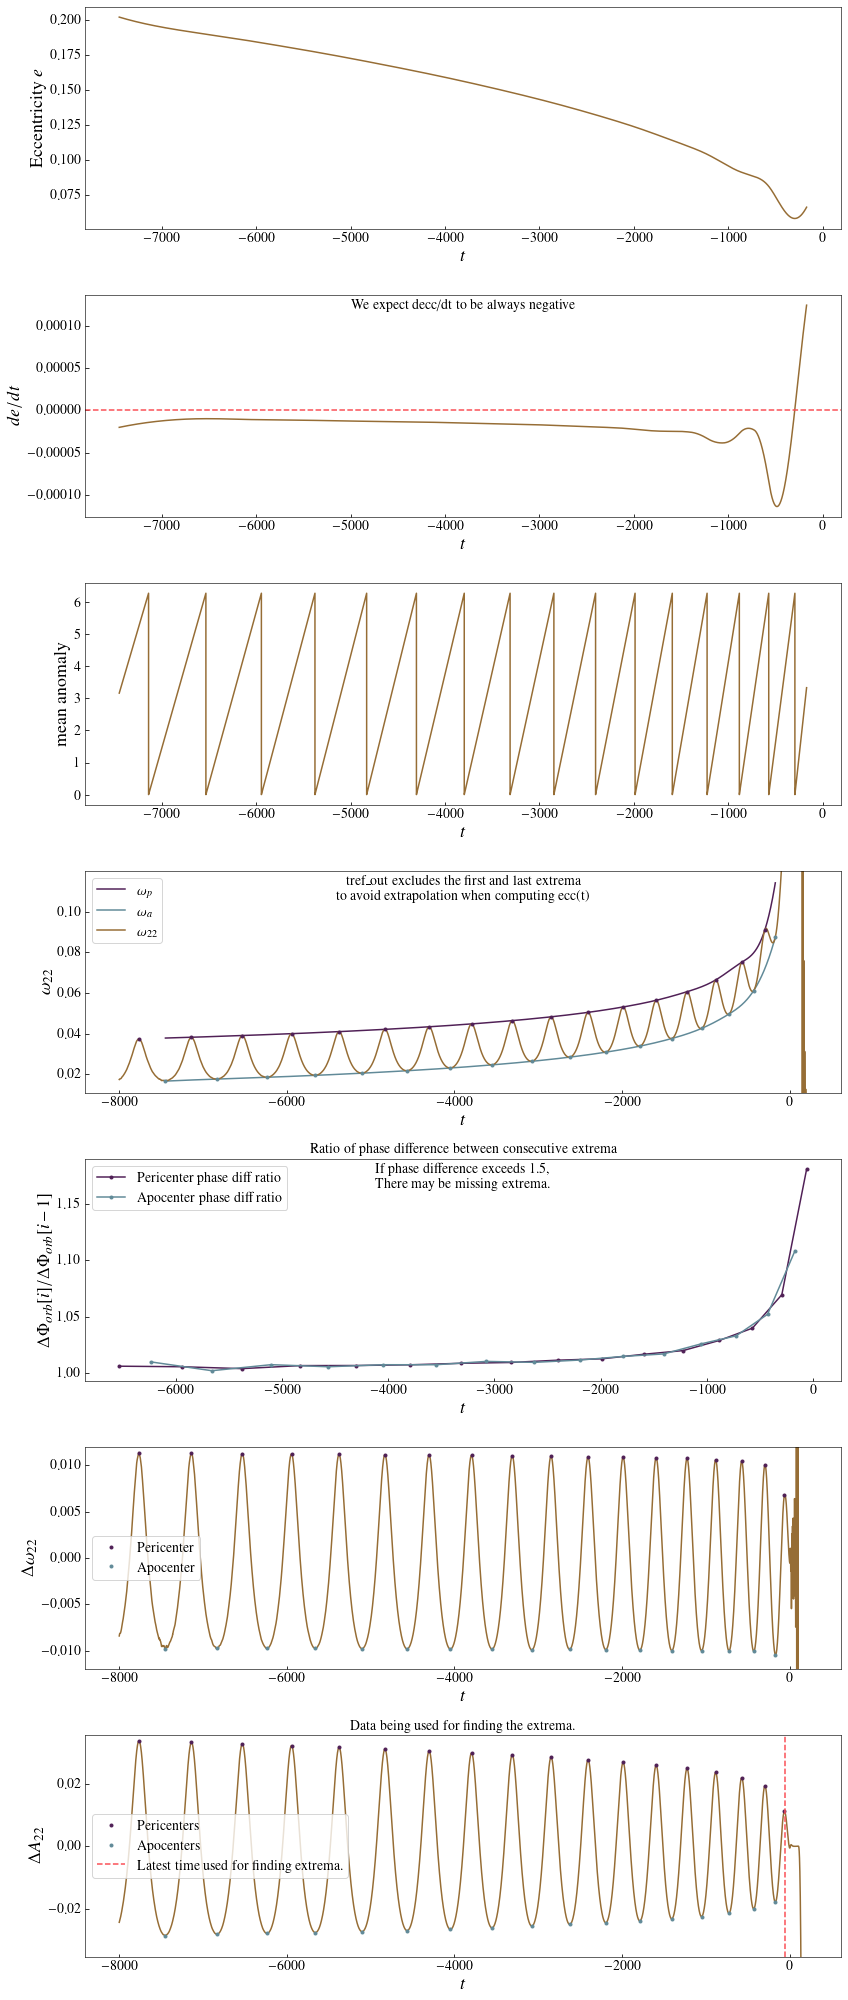

In [10]:
fig, ax = gwecc_object.make_diagnostic_plots()

Let's look at each of these plots separately.

**Eccentricity vs Time:**

This plot shows the evolution of eccentricity as a function of time.

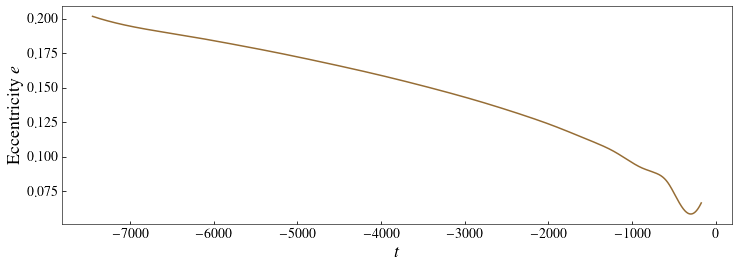

In [11]:
fig, ax = gwecc_object.plot_measured_ecc()

**$de/dt$ vs Time:**

This plot shows the first derivative of eccentricity as a function of time. The eccentricity should be a monotonically decreasing function of time. Therefore, wherever $de/dt$ becomes positive implies non-monotonic eccentricity due unphysical features.

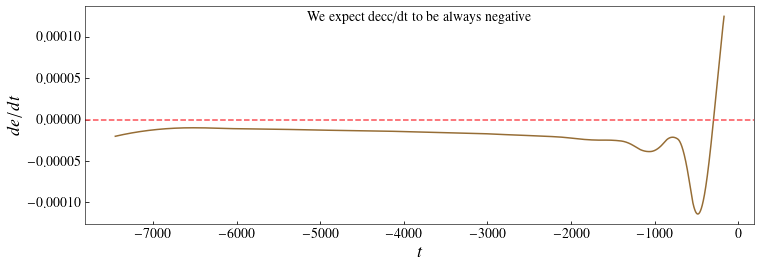

In [12]:
fig, ax = gwecc_object.plot_decc_dt()

**Mean anomaly vs Time:**

This plot shows the evolution of mean anomaly as a function of time

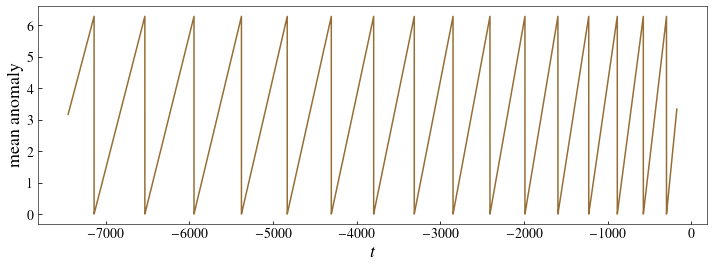

In [13]:
fig, ax = gwecc_object.plot_mean_ano()

**$\omega_{22}$ with the locations of apocenter and pericenter**

This plot shows the $\omega_{22}(t)$ with the locations of the apocenters and pericenters that are being used for measuring eccentricity indicated by circles.<br>
This would show if the method is missing any peaks/troughs or selecting one which is not a peak/trough.

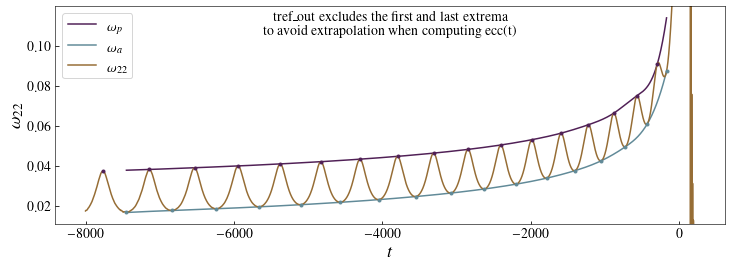

In [14]:
fig, ax = gwecc_object.plot_omega22()

**Ratio of $\Delta \phi_{\mathrm{orb}}$ between consecutive peaks/troughs vs Time:**

$\Delta \phi_{\mathrm{orb}}^{i}/\Delta \phi_{\mathrm{orb}}^{i-1}$, where $\Delta \phi_{\mathrm{orb}}^{i}$
is the change in orbital phase from the previous extrema to the ith extrema. This helps look for missing extrema, as there will be a drastic (roughly factor of 2) change in
$\Delta \phi_{\mathrm{orb}}^{i}$ if there is a missing extrema, and the ratio will go from ~1 to ~2.

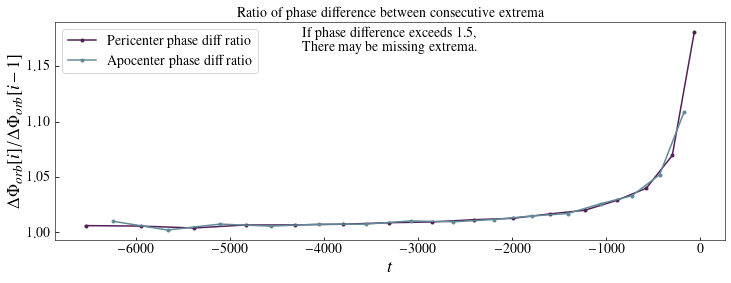

In [15]:
fig, ax = gwecc_object.plot_phase_diff_ratio_between_pericenters()

**$\Delta A_{22}$ vs Time:**

$\Delta A_{22}$ is the residual amplitude of the 22 mode, defined as $\Delta A_{22} = A_{22}(e) - A_{22}(e=0)$, where we substract the 22 mode amplitude of the qausi-circular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode amplitude of the eccentric waveform.
**NOTE:** This is available only if the provided data dictionary contains zeroecc data.

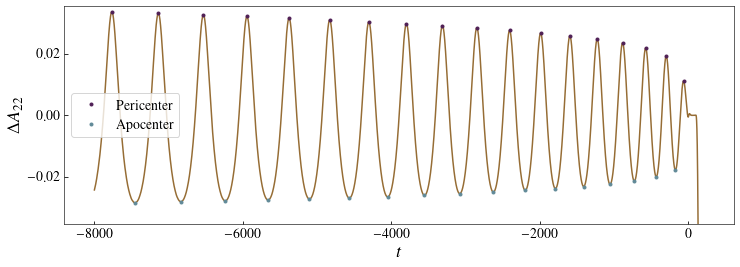

In [16]:
fig, ax = gwecc_object.plot_residual_amp22()

**$\Delta \omega_{22}$ vs Time:**

$\Delta \omega_{22}$ is the residual omega of the 22 mode, defined as $\Delta \omega_{22} = \omega_{22}(e) - \omega_{22}(e=0)$, where we substract the 22 mode omega of the qausi-circular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode omega of the eccentric waveform.
**NOTE:** This is available only if the provided data dictionary contains zeroecc data.

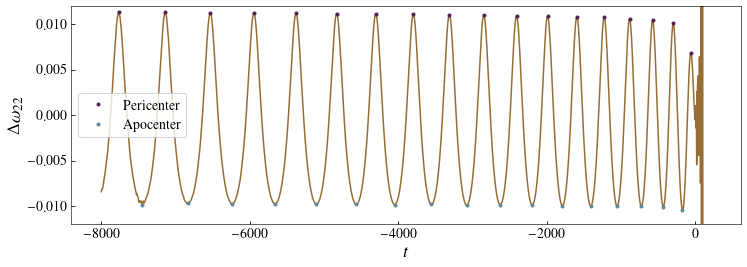

In [17]:
fig, ax = gwecc_object.plot_residual_omega22()

### Data being used to find extrema

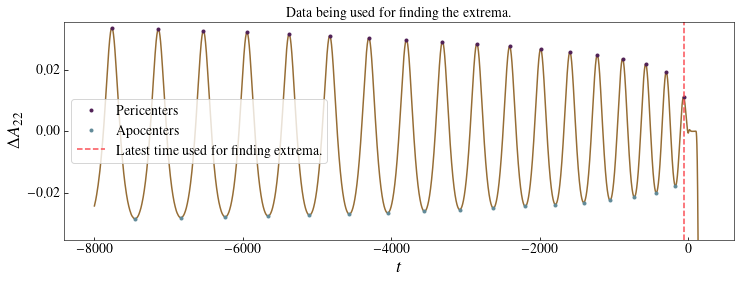

In [18]:
fig, ax = gwecc_object.plot_data_used_for_finding_extrema()